In [1]:
import os, sys, urllib, gzip
sys.path.append('/home/rui/pylearn2')
from __future__ import print_function
try:
    import cPickle as pickle
except:
    import pickle
sys.setrecursionlimit(10000)

import numpy as np
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh
from lasagne.updates import nesterov_momentum
from lasagne.objectives import categorical_crossentropy
import pylearn2
from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
from lasagne.regularization import regularize_layer_params, l2, l1
import theano
import theano.tensor as T
import time
import lasagne
from lasagne.layers import Conv2DLayer as Conv2DLayerSlow
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerSlow
try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayerFast
    print('Using cuda_convnet (faster)')
except ImportError:
    from lasagne.layers import Conv2DLayer as Conv2DLayerFast
    from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerFast
    print('Using lasagne.layers (slower)')
import matplotlib
matplotlib.use('Agg') # Change matplotlib backend, in case we have no X server running..
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import Image as IPImage
from PIL import Image
import sklearn
from sklearn import datasets
batch_size = 40
Conv2DLayer = lasagne.layers.Conv2DLayer

def load_data():
    
    face=sklearn.datasets.fetch_olivetti_faces(shuffle=True)
    train_set=(face.data[0:200,].reshape((200,1,64,64)),face.target[0:200,].astype(np.int32))
    test_set =(face.data[200:400,].reshape((200,1,64,64)),face.target[200:400,].astype(np.int32))
    rval = [train_set, test_set]
    return rval

Using gpu device 0: GeForce GTX 750 Ti (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 3007.)


Using cuda_convnet (faster)


In [2]:
train_set, test_set = load_data()
train_face = train_set[0]

In [3]:
def get_picture_array(X, rescale=2):
    array = X.reshape(64,64)
    array = np.clip(array, a_min = 0, a_max = 255)
    return  array.repeat(rescale, axis = 0).repeat(rescale, axis = 1).astype(np.uint8())

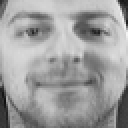

In [4]:
pic_array = get_picture_array(train_face[5]*255)
image = Image.fromarray(pic_array)
image.save('temp.png', format="PNG")  
IPImage('temp.png')

In [5]:
train_face_out = train_face.reshape((train_face.shape[0], -1))

In [6]:
conv_num_filters = 16
filter_size = 5
pool_size = 2
encode_size = 48
dense_mid_size = 128
pad_in = 'valid'    
pad_out = 'full'

In [7]:
def build_cnn(input_var=None):
    
    network = InputLayer(shape=(None,  train_face.shape[1], train_face.shape[2], train_face.shape[3]),input_var=input_var)
    
    network = Conv2DLayerFast(network, num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh, filter_size=filter_size, pad=pad_in)

    network = Conv2DLayerFast(network, num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh, filter_size=filter_size, pad=pad_in)

    network = MaxPool2DLayerFast(network, pool_size=pool_size)

    network = Conv2DLayerFast(network, num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh, filter_size=filter_size, pad=pad_in)
    
    network = Conv2DLayerFast(network, num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh, filter_size=filter_size, pad=pad_in)

    network = MaxPool2DLayerFast(network, pool_size=pool_size)
    
    network = ReshapeLayer(network, shape =(([0], -1)))
    
    network = DenseLayer(network, num_units= dense_mid_size, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh)
    
    encode_layer = DenseLayer(network, name= 'encode', num_units= encode_size, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh)
    
    action_layer = DenseLayer(encode_layer, name= 'action', num_units= encode_size, W=lasagne.init.Orthogonal(1.0),\
                            nonlinearity=lasagne.nonlinearities.tanh)
    
    network = DenseLayer(action_layer, num_units= 3200, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh)
    
    network = ReshapeLayer(network, shape =(([0], 2*conv_num_filters, 10, 10)))
    
    network = Upscale2DLayer(network, scale_factor = pool_size)
    
    network = Conv2DLayerFast(network, num_filters=2 * conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh, filter_size=filter_size, pad=pad_out)
    
    network = Conv2DLayerFast(network, num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh, filter_size=filter_size, pad=pad_out)

    network = Upscale2DLayer(network, scale_factor = pool_size)
    
    network = Conv2DLayerFast(network, num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh, filter_size=filter_size, pad=pad_out)

    network = Conv2DLayerSlow(network, num_filters=1, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.sigmoid, filter_size=filter_size, pad=pad_out)
    
    network = ReshapeLayer(network, shape =(([0], -1)))

    return network

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

## Load pre-trained weights

In [ ]:
input_var = T.tensor4('inputs')
target_var = T.matrix('targets')
# Create neural network model (depending on first command line parameter)
network = build_cnn(input_var)
with np.load('CAE_face.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
lasagne.layers.set_all_param_values(network, param_values)
reconstructed = lasagne.layers.get_output(network)
loss = lasagne.objectives.squared_error(reconstructed, target_var)
loss = loss.mean()
params = lasagne.layers.get_all_params(network, trainable=True)

In [8]:
num_epochs = 1000
input_var = T.tensor4('inputs')
target_var = T.matrix('targets')
learnrate=0.01
# Create neural network model (depending on first command line parameter)
print("Building model and compiling functions...")
network = build_cnn(input_var)
reconstructed = lasagne.layers.get_output(network)
loss = lasagne.objectives.squared_error(reconstructed, target_var)
loss = loss.mean()
params = lasagne.layers.get_all_params(network, trainable=True)
# updates = lasagne.updates.nesterov_momentum(
#     loss, params, learning_rate=learnrate, momentum=0.975)
updates = lasagne.updates.rmsprop(loss, params, learning_rate=learnrate)
train_fn = theano.function([input_var, target_var], loss, updates=updates,on_unused_input='warn')
print("Starting training...")

for epoch in range(num_epochs):
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(train_face, train_face_out, 200, shuffle=False):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

        # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    # Optionally, you could now dump the network weights to a file like this:

Building model and compiling functions...
Starting training...
Epoch 1 of 1000 took 0.730s
  training loss:		0.032523
Epoch 2 of 1000 took 0.746s
  training loss:		0.030011
Epoch 3 of 1000 took 0.760s
  training loss:		0.031232
Epoch 4 of 1000 took 0.753s
  training loss:		0.031644
Epoch 5 of 1000 took 0.734s
  training loss:		0.029590
Epoch 6 of 1000 took 0.758s
  training loss:		0.028783
Epoch 7 of 1000 took 0.736s
  training loss:		0.029179
Epoch 8 of 1000 took 0.759s
  training loss:		0.028153
Epoch 9 of 1000 took 0.732s
  training loss:		0.030876
Epoch 10 of 1000 took 0.755s
  training loss:		0.028307
Epoch 11 of 1000 took 0.733s
  training loss:		0.025603
Epoch 12 of 1000 took 0.733s
  training loss:		0.026766
Epoch 13 of 1000 took 0.740s
  training loss:		0.040464
Epoch 14 of 1000 took 0.705s
  training loss:		0.033592
Epoch 15 of 1000 took 0.704s
  training loss:		0.027857
Epoch 16 of 1000 took 0.756s
  training loss:		0.025508
Epoch 17 of 1000 took 0.704s
  training loss:		0.0

In [19]:
output_func = theano.function([input_var], [lasagne.layers.get_output(network)])
data_pred = np.zeros((200,4096))
i = 0
for batch in iterate_minibatches(train_face, train_face_out, 200, shuffle=False):
    inputs, targets = batch
    data_pred[1000*i:1000*(i+1),:] = output_func(inputs)[0]
    i+=1

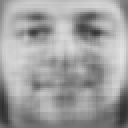

In [22]:
pic_array = get_picture_array(data_pred[5]*255)
image = Image.fromarray(pic_array)
image.save('temp.png', format="PNG")  
IPImage('temp.png')

In [16]:
np.savez('CAE_face.npz', *lasagne.layers.get_all_param_values(network))

In [24]:
num_epochs = 500
updates = lasagne.updates.nesterov_momentum(
    loss, params, learning_rate=0.02, momentum=0.975)
# updates = lasagne.updates.rmsprop(
#     loss, params[10:12], learning_rate=0.01)
train_fn = theano.function([input_var, target_var], loss, updates=updates,on_unused_input='warn')
print("Starting training...")
best_err = 0.003620
for epoch in range(num_epochs):
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(train_face, train_face_out, 200, shuffle=False):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1
        # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    if train_err / train_batches < best_err:
        best_err = train_err / train_batches
        np.savez('CAE_face.npz', *lasagne.layers.get_all_param_values(network))


Starting training...
Epoch 1 of 500 took 0.752s
  training loss:		0.003627
Epoch 2 of 500 took 0.758s
  training loss:		0.003627
Epoch 3 of 500 took 0.770s
  training loss:		0.003627
Epoch 4 of 500 took 0.790s
  training loss:		0.003627
Epoch 5 of 500 took 0.768s
  training loss:		0.003627
Epoch 6 of 500 took 0.761s
  training loss:		0.003627
Epoch 7 of 500 took 0.777s
  training loss:		0.003627
Epoch 8 of 500 took 0.704s
  training loss:		0.003627
Epoch 9 of 500 took 0.704s
  training loss:		0.003627
Epoch 10 of 500 took 0.703s
  training loss:		0.003627
Epoch 11 of 500 took 0.701s
  training loss:		0.003627
Epoch 12 of 500 took 0.737s
  training loss:		0.003627
Epoch 13 of 500 took 0.704s
  training loss:		0.003626
Epoch 14 of 500 took 0.705s
  training loss:		0.003626
Epoch 15 of 500 took 0.705s
  training loss:		0.003626
Epoch 16 of 500 took 0.705s
  training loss:		0.003626
Epoch 17 of 500 took 0.748s
  training loss:		0.003626
Epoch 18 of 500 took 0.704s
  training loss:		0.00362